#### IMPORT

In [1]:
import os, platform
import py7zr

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer

from keras.models import load_model

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc

from itertools import cycle
from scipy import interp
from scipy.optimize import brentq
from scipy.interpolate import interp1d

#### PARAMETERS
- Set the condition
> * N_FEATURES: Number of Features
> * CHECK_BLANKS: Check for blank data. If any blank data is found, the whole row of data will be deleted.
> * CHECK_CLASS_IMBALANCE: Check for dataset class imbalance. The more balance the dataset, the less biases the model will be.

In [2]:
##############################
# # deep learning features # #
##############################
SEED = 1005 # random seed for reproducibility

# should make this dynamic
TIMESTEPS = 1

###############
# # preview # #
###############
f = False
t = True

# model testing
TEST_MODEL = True
CON_MATRIX = True
ROC_GRAPH = True

###############
# # dataset # #
###############
CLASSES_COL_NAME = "Subject"
CLASSES_COL_NUM = 0
FEATURES_COL_NUM = 3

#################
# # sns theme # #
#################
# sns.set_theme(style="darkgrid") # (dark background with white gridlines)
sns.set_theme(style="whitegrid") # (white background with grey gridlines)
# sns.set_theme(style="dark") # (dark background with no gridlines)
# sns.set_theme(style="white") # (white background with no gridlines)
# sns.set_theme(style="ticks") # (white background with axis ticks and no gridlines)

### Load Model and Prepare Dataset

In [3]:
# divide data into features X and target (classes) Y
def prepare_dataset(MODEL_PATH, ACTUAL_DATASET_PATH, CLASSES_COL_NUM, FEATURES_COL_NUM):
    ##################
    # # load model # #
    ##################
    model = load_model(MODEL_PATH)

    # load dataset
    pred_df = pd.read_csv(ACTUAL_DATASET_PATH)
#     pred_df.head()

    ########################
    # # predict all rows # #
    ########################
    pred_row=pred_df.iloc[:,FEATURES_COL_NUM:]

    ##################
    # # shape data # #
    ##################
    pred_row = pred_row.values.tolist()
    pred_arr = np.asarray(pred_row, dtype=np.float32)
    pred_arr = np.reshape(pred_arr, (pred_arr.shape[0], TIMESTEPS, pred_arr.shape[1]))

    #####################
    # # get Y classes # #
    #####################

    actual_np = pred_df.values[:,CLASSES_COL_NUM]
    Y = pred_df.values[:,CLASSES_COL_NUM].astype(str)
    Y = Y.reshape(-1, 1)
    lb = LabelBinarizer().fit(Y)
    Y = lb.transform(Y)

    print("LabelBinarizer is able to decipher: ")
    print(lb.classes_)
    print("\n")

    class_list = lb.classes_.tolist()
    n_classes = len(class_list)

    return model, lb, class_list, n_classes, pred_arr, actual_np

### Prediction 

In [4]:
def prediction(model, lb, pred_arr, actual_np):
    ####################################
    # # get prediction and its label # #
    ####################################

    pred_proba = model.predict(pred_arr)

    pred = lb.inverse_transform(pred_proba)
    acc = np.max(pred_proba, axis=1)
    actual = lb.fit_transform(actual_np)

    match_list = []

    for _ in range(actual_np.size):
        if pred[_] == actual_np[_]:
            match_list.append("match")
        else:
            match_list.append("nope")

    match_count = match_list.count("match")
    total_count = len(match_list)

    match_header = str(match_count) + "/" + str(total_count) + " (" + str(match_count/total_count*100)+ "%)"
    match_np = np.array(match_list)

    exported_output = np.column_stack((actual_np, pred))
    exported_output = np.column_stack((exported_output, acc))
    exported_output = np.column_stack((exported_output, match_np))

    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)

    df = pd.DataFrame(data=exported_output, index=None, columns=['Actual', 'Prediction', 'Accuracy', match_header])
    # print(df)

    print("Accuracy of the Model is: " + str(match_header))
    
    return pred_proba, actual

In [5]:
def test_accuracy(lb, y_pred, y_test):
    acc = accuracy_score(lb.inverse_transform(y_test), lb.inverse_transform(y_pred))
    print("Testing accuracy: %.3f%%" % (acc*100))

In [6]:
def confu_matrix(lb, y_pred, y_test):
    # confusion matrix
    print(str(len(y_pred)) + " is the number of test value in live test")
    cm = confusion_matrix(lb.inverse_transform(y_test), lb.inverse_transform(y_pred))
    df_cm = pd.DataFrame(cm, index = [i for i in np.unique(lb.inverse_transform(y_test))],
                         columns = [i for i in np.unique(lb.inverse_transform(y_test))])

    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=True, cmap="BuPu")

In [7]:
def roc_individual(lb, y_pred, y_test):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    for i in range(n_classes):
        plt.figure()
        lw = 2
        plt.plot(
            fpr[i],
            tpr[i],
            color="darkorange",
            lw=lw,
            label="ROC curve (area = %0.2f)" % roc_auc[i],
        )
        plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
        plt.xlim([-0.005, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve (" + str(lb.classes_[i]) + ")")
        plt.legend(loc="lower right")
        plt.show()

In [8]:
def roc_multi(lb, y_pred, y_test):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    lw=2
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], thresholds = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # first aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    colors = cycle(["aqua", "darkorange", "cornflowerblue", "lightgreen", "purple"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class {0} (area = {1:0.2f})".format(lb.classes_[i], roc_auc[i]),
        )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([-0.005, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (Multiclass)")
    plt.legend(loc="lower right")
    plt.show()

In [9]:
def roc_avg(lb, y_pred, y_test):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    fpr, tpr, threshold = roc_curve(y_test.ravel(), y_pred.ravel())

    # calculate equal-error-rate
    eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)

    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='AUC = {:.3f}, EER = {:.3f}'.format(auc(fpr, tpr), eer))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('Average ROC Curve')
    plt.legend(loc='best')
    plt.show()

## set01_01_original

In [10]:
DATASET_DIR_NAME = "dataset\set01\\01_original"
ACTUAL_DATASET_NAME = "test"

MODEL_DIR_NAME = "dataset\set01\\01_original"
MODEL_NAME = "model_" + "set01_01_original"

RESULT_DIR_NAME = "dataset\set01\\01_original"
RESULT_NAME = "result_" + "set01_01_original" 

DATASET_DIR_PATH = os.path.join(os.getcwd(), DATASET_DIR_NAME)
ACTUAL_DATASET_PATH = os.path.join(DATASET_DIR_PATH, ACTUAL_DATASET_NAME + ".csv")

MODEL_DIR_PATH = os.path.join(os.getcwd(), MODEL_DIR_NAME)
MODEL_PATH = os.path.join(MODEL_DIR_PATH, MODEL_NAME + ".h5")

RESULT_DIR_PATH = os.path.join(os.getcwd(), RESULT_DIR_NAME)
RESULT_PATH = os.path.join(RESULT_DIR_PATH, RESULT_NAME + ".csv")

model, lb, class_list, n_classes, pred_arr, actual_np = \
prepare_dataset(MODEL_PATH, ACTUAL_DATASET_PATH, CLASSES_COL_NUM, FEATURES_COL_NUM)
pred_proba, actual = prediction(model, lb, pred_arr, actual_np)

LabelBinarizer is able to decipher: 
['andy' 'azfar' 'ch' 'cy' 'gerald' 'jc' 'jonah' 'qikai' 'ys' 'zen']


Accuracy of the Model is: 33/80 (41.25%)


Testing accuracy: 41.250%
80 is the number of test value in live test


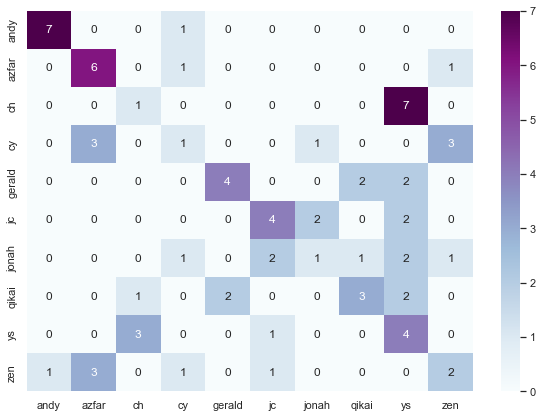

In [11]:
test_accuracy(lb, pred_proba, actual)
confu_matrix(lb, pred_proba, actual)

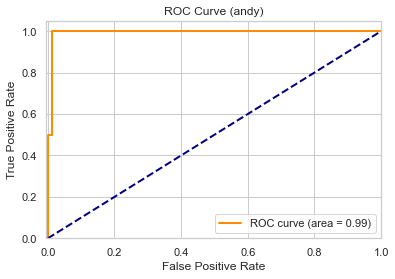

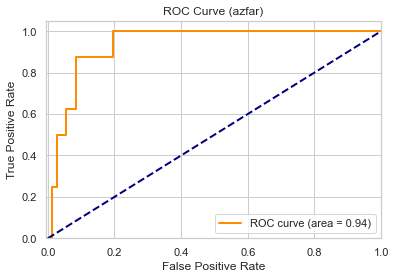

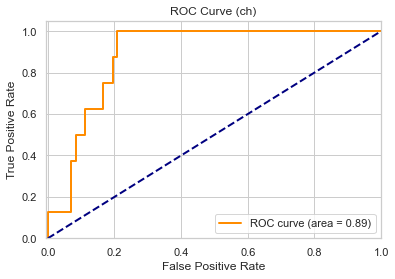

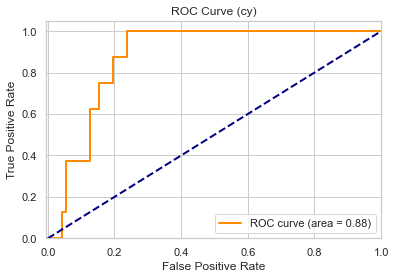

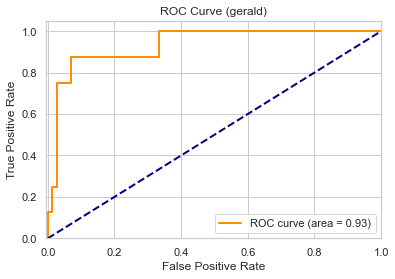

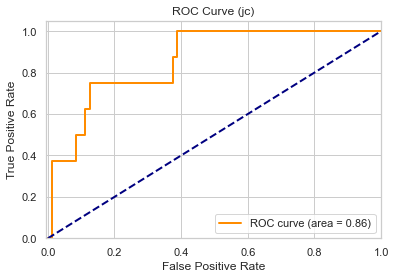

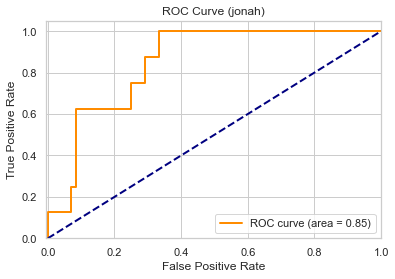

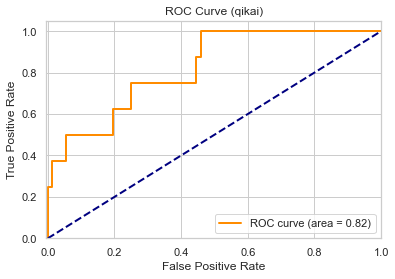

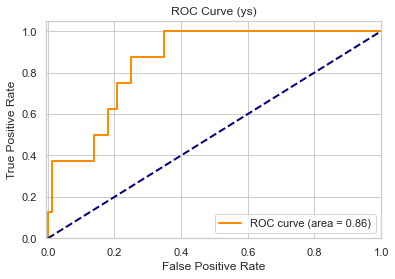

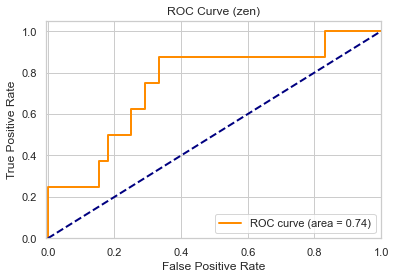

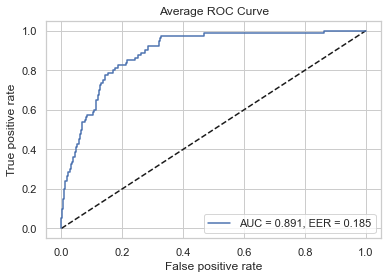

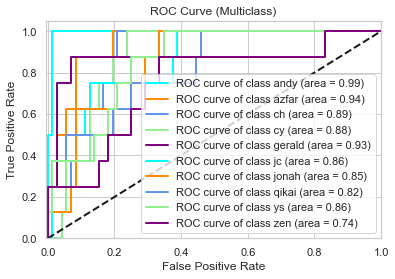

In [12]:
roc_individual(lb, pred_proba, actual)
roc_avg(lb, pred_proba, actual)
roc_multi(lb, pred_proba, actual)

## set01_03_pair

In [13]:
DATASET_DIR_NAME = "dataset\set01\\03_pair"
ACTUAL_DATASET_NAME = "pair_test"

MODEL_DIR_NAME = "dataset\set01\\03_pair"
MODEL_NAME = "model_" + "set01_03_pair"

RESULT_DIR_NAME = "dataset\set01\\03_pair"
RESULT_NAME = "result_" + "set01_03_pair"

DATASET_DIR_PATH = os.path.join(os.getcwd(), DATASET_DIR_NAME)
ACTUAL_DATASET_PATH = os.path.join(DATASET_DIR_PATH, ACTUAL_DATASET_NAME + ".csv")

MODEL_DIR_PATH = os.path.join(os.getcwd(), MODEL_DIR_NAME)
MODEL_PATH = os.path.join(MODEL_DIR_PATH, MODEL_NAME + ".h5")

RESULT_DIR_PATH = os.path.join(os.getcwd(), RESULT_DIR_NAME)
RESULT_PATH = os.path.join(RESULT_DIR_PATH, RESULT_NAME + ".csv")

model, lb, class_list, n_classes, pred_arr, actual_np = \
prepare_dataset(MODEL_PATH, ACTUAL_DATASET_PATH, CLASSES_COL_NUM, FEATURES_COL_NUM)
pred_proba, actual = prediction(model, lb, pred_arr, actual_np)

LabelBinarizer is able to decipher: 
['andy' 'azfar' 'ch' 'cy' 'gerald' 'jc' 'jonah' 'qikai' 'ys' 'zen']


Accuracy of the Model is: 271/480 (56.458333333333336%)


Testing accuracy: 56.458%
480 is the number of test value in live test


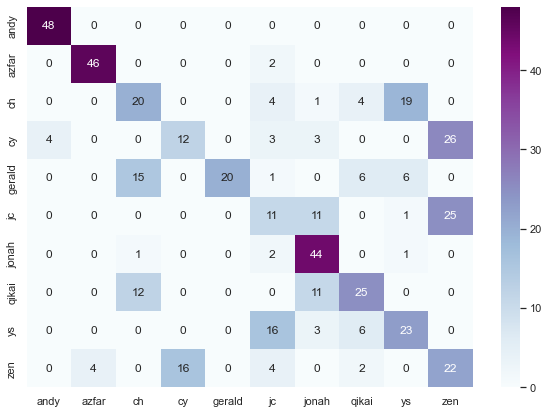

In [14]:
test_accuracy(lb, pred_proba, actual)
confu_matrix(lb, pred_proba, actual)

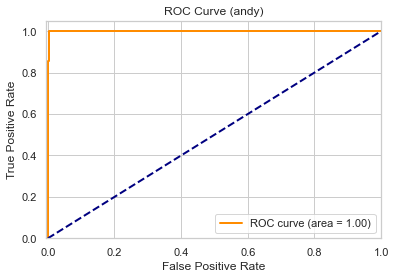

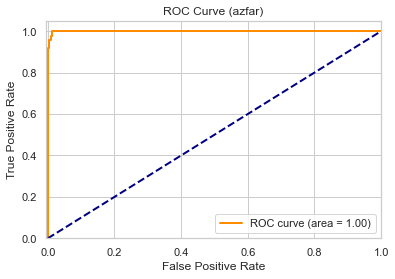

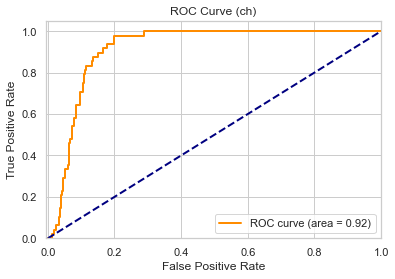

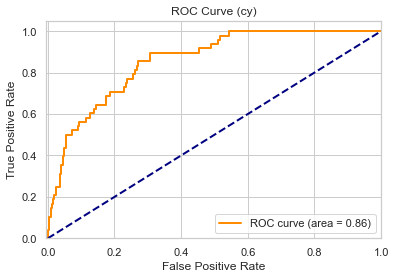

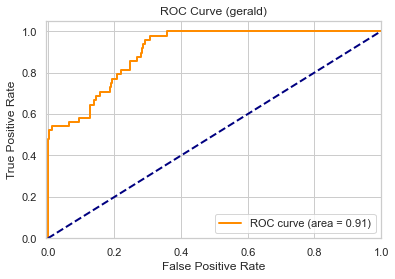

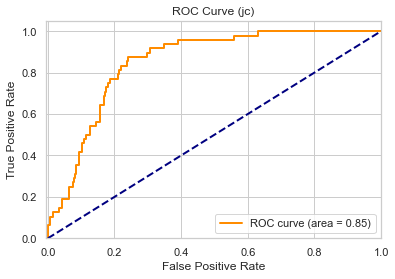

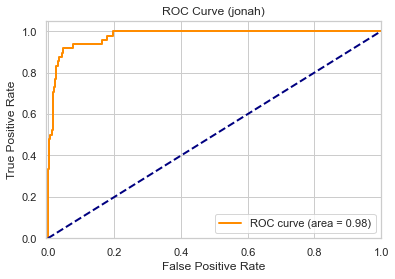

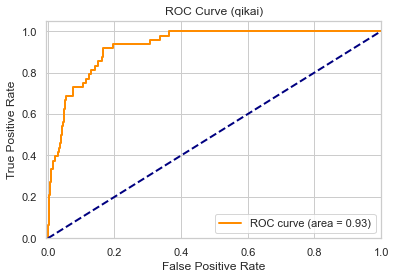

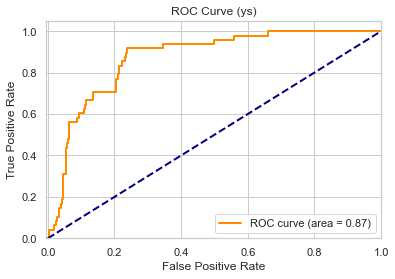

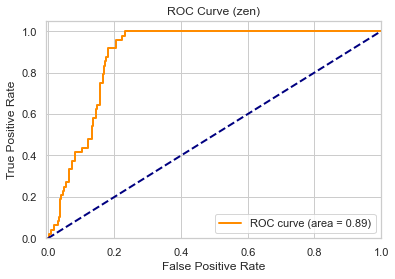

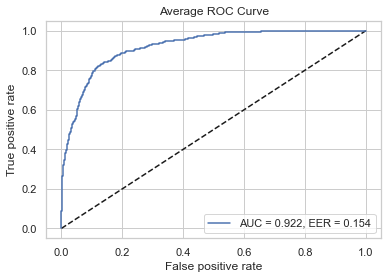

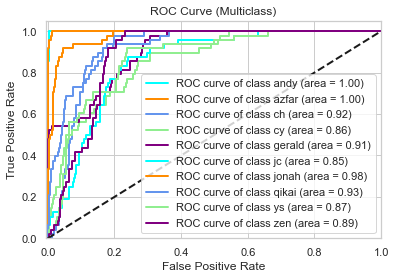

In [15]:
roc_individual(lb, pred_proba, actual)
roc_avg(lb, pred_proba, actual)
roc_multi(lb, pred_proba, actual)